In [ ]:
import pandas as pd
import numpy as np
import json
from tqdm import tqdm
import networkx as nx

!pip install elsapy

from elsapy.elsclient import ElsClient
from elsapy.elsprofile import ElsAuthor, ElsAffil
from elsapy.elsdoc import FullDoc, AbsDoc
from elsapy.elssearch import ElsSearch

INFO:elsapy.elsclient:Module loaded.
INFO:elsapy.elsentity:Module loaded.
INFO:elsapy.utils:Module loaded.
INFO:elsapy.elsprofile:Module loaded.
INFO:elsapy.elsdoc:Module loaded.
INFO:elsapy.elssearch:Module loaded.


In [ ]:
api_key = ""

# Crear cliente directamente con el API key
client = ElsClient(api_key)

In [ ]:
# Query
query = "TITLE-ABS-KEY(poverty) AND PUBYEAR > 2024"
doc_srch = ElsSearch(query, 'scopus')
doc_srch.execute(client, get_all=False)

INFO:elsapy.elsclient:Sending GET request to https://api.elsevier.com/content/search/scopus?query=TITLE-ABS-KEY%28poverty%29+AND+PUBYEAR+%3E+2024
INFO:elsapy.utils:Converting prism:coverDate


In [ ]:
## Procesar los resultados

# Creación listas vacías para almacenar los datos
links, titles, years, journals, authors, cited_count, dois = [], [], [], [], [], [], []

# Iteración sobre los resultados de la búsqueda
for j in doc_srch.results:
    link = j['link'][0]['@href'] #obtención enlace
    links.append(link)

    title = j.get('dc:title', 'No Title') #obtención de Título
    titles.append(title)

    year = j.get('prism:coverDate', 'No Date') #obtención de fecha de publicación
    years.append(year)

    journal = j.get('prism:publicationName', 'No Journal') #obtención nombre del journal
    journals.append(journal)

    author = j.get('dc:creator', 'No Author') #obtención nombre del autor
    authors.append(author)

    count = j.get('citedby-count', 0) #obtención de número de citas
    cited_count.append(count)

    doi = j.get('prism:doi', 'No DOI')  # obtención del DOI
    dois.append(doi)

    # Generar el DataFrame
article_df = pd.DataFrame({
    'title': titles,
    'authors': authors,
    'journal': journals,
    'date': years,
    'link': links,
    'cited_count': cited_count,
    'doi': dois
})

# Seleccionamos solo los primeros 600 datos para poder trabajar de mejor forma la data.
df = article_df.head(600)
df = df.sort_values('cited_count', ascending = False)

In [ ]:
import pandas as pd
import requests

def get_authors_by_doi(doi):
    url = f"https://api.crossref.org/works/{doi}"
    response = requests.get(url)

    if response.status_code != 200:
        raise Exception(f"Error fetching data from CrossRef API: {response.status_code}")

    data = response.json()
    authors = data.get('message', {}).get('author', [])

    author_names = [f"{author.get('given', '')} {author.get('family', '')}" for author in authors]
    return ', '.join(author_names)

# Iterar sobre el DataFrame y llenar la columna 'authors'
errores = []

for index, row in df.iterrows():
    doi = row['doi']
    try:
        authors = get_authors_by_doi(doi)
        df.at[index, 'authors'] = authors
    except Exception as e:
      #conteo de errores
        errores.append(doi)
        pass

print('No matching:')
print(len(errores))

No matching:
2


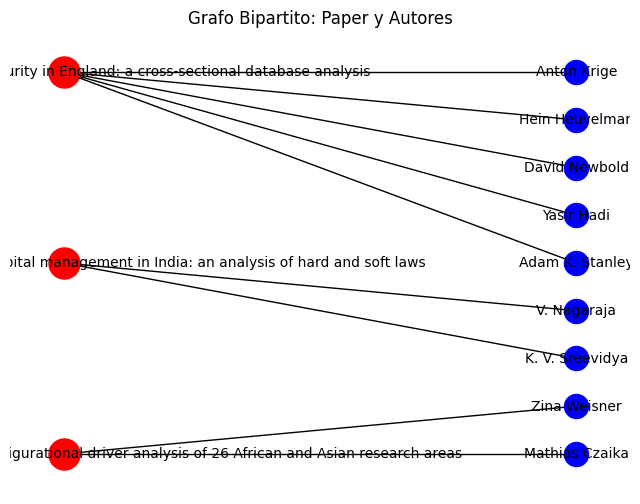

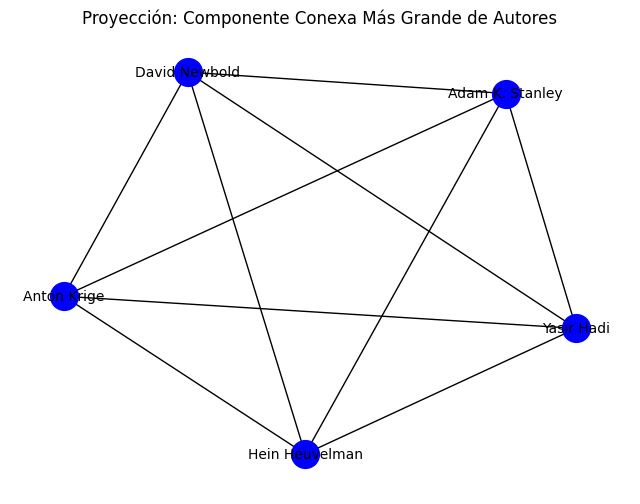

In [ ]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import math

### 1. Grafo Bipartito
# Selecciono tres para hacerlo rapido nomas
df_bipartito = df.tail(3)

# grafo bipartito
B = nx.Graph()

for idx, row in df_bipartito.iterrows():
    paper = row['title']
    # Agrega el nodo del paper con atributo 'bipartite' = 'paper'
    B.add_node(paper, bipartite='paper')
    # Separa los autores usando el delimitador ", "
    author_list = [a.strip() for a in row['authors'].split(", ") if a.strip()]
    for author in author_list:
        B.add_node(author, bipartite='author')
        B.add_edge(paper, author)

# Separar los nodos por tipo
paper_nodes = [n for n, d in B.nodes(data=True) if d['bipartite'] == 'paper']
author_nodes = [n for n, d in B.nodes(data=True) if d['bipartite'] == 'author']

# --- Grafo Bipartito ---
# layout bipartito
pos = nx.bipartite_layout(B, paper_nodes)
plt.figure(figsize=(8,6))
nx.draw_networkx_nodes(B, pos, nodelist=paper_nodes, node_color='red', node_size=500)
nx.draw_networkx_nodes(B, pos, nodelist=author_nodes, node_color='blue', node_size=300)
nx.draw_networkx_edges(B, pos)
nx.draw_networkx_labels(B, pos, font_size=10)
plt.axis('off')
plt.title("Grafo Bipartito: Paper y Autores")
plt.show()

# --- Proyección en Autores ---
# Proyecta el grafo sobre los nodos de autores
G_authors = nx.algorithms.bipartite.weighted_projected_graph(B, author_nodes)

# Extraer la componente conexa más grande
largest_cc = max(nx.connected_components(G_authors), key=len)
subgraph = G_authors.subgraph(largest_cc)

plt.figure(figsize=(8,6))
pos_proj = nx.spring_layout(subgraph)
nx.draw_networkx_nodes(subgraph, pos_proj, node_color='blue', node_size=400)
nx.draw_networkx_edges(subgraph, pos_proj)
nx.draw_networkx_labels(subgraph, pos_proj, font_size=10)
plt.axis('off')
plt.title("Proyección: Componente Conexa Más Grande de Autores")
plt.show()

